#Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, SimpleRNN, LSTM, Masking, GRU

#Reading Dataset

In [4]:
ds = pd.read_csv('/content/drive/MyDrive/EFQM/5-Multi label classification/Multivariate_pollution.csv')
ds.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


#Check target values

In [5]:
print('snow data', ds['snow'].unique())
print('rain data', ds['rain'].unique())

snow data [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 19 20 21 22 23 24 25
 26 27 14 18]
rain data [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


#Check data

In [6]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


#Creating time features

In [7]:
ds['date'] = pd.to_datetime(ds['date'])
ds['year'] = ds['date'].dt.year
ds['month'] = ds['date'].dt.month
ds['day'] = ds['date'].dt.day
ds['hour'] = ds['date'].dt.hour


ds.drop(['date'], axis=1, inplace=True)
ds.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,year,month,day,hour
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010,1,2,0
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010,1,2,1
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010,1,2,2
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010,1,2,3
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010,1,2,4


#create dummy data from wind_dir feature

In [8]:
dummy_wind = pd.get_dummies(ds['wnd_dir'])
ds = pd.concat([ds, dummy_wind], axis=1)
ds.drop(['wnd_dir'], axis=1, inplace=True)
ds.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,year,month,day,hour,NE,NW,SE,cv
0,129.0,-16,-4.0,1020.0,1.79,0,0,2010,1,2,0,False,False,True,False
1,148.0,-15,-4.0,1020.0,2.68,0,0,2010,1,2,1,False,False,True,False
2,159.0,-11,-5.0,1021.0,3.57,0,0,2010,1,2,2,False,False,True,False
3,181.0,-7,-5.0,1022.0,5.36,1,0,2010,1,2,3,False,False,True,False
4,138.0,-7,-5.0,1022.0,6.25,2,0,2010,1,2,4,False,False,True,False


#Feature Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler

X = ds.drop(columns=['snow', 'rain'])
y = ds[['snow', 'rain']]

scaler = MinMaxScaler()
scaled_x = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

ds = pd.concat([scaled_x, y], axis=1)

ds.head()

,pollution,dew,temp,press,wnd_spd,year,month,day,hour,NE,NW,SE,cv,snow,rain
0,0.129779,0.352941,0.245902,0.527273,0.002290,0.0,0.0,0.033333,0.000000,0.0,0.0,1.0,0.0,0,0
1,0.148893,0.367647,0.245902,0.527273,0.003811,0.0,0.0,0.033333,0.043478,0.0,0.0,1.0,0.0,0,0
2,0.159960,0.426471,0.229508,0.545455,0.005332,0.0,0.0,0.033333,0.086957,0.0,0.0,1.0,0.0,0,0
3,0.182093,0.485294,0.229508,0.563636,0.008391,0.0,0.0,0.033333,0.130435,0.0,0.0,1.0,0.0,1,0
4,0.138833,0.485294,0.229508,0.563636,0.009912,0.0,0.0,0.033333,0.173913,0.0,0.0,1.0,0.0,2,0


#Windowing

In [10]:
X = []
y = []

sequence_length = 16
for i in range(sequence_length, len(ds)):
    X.append(ds.iloc[i-sequence_length:i].values)
    y.append(ds.iloc[i][['snow', 'rain']])

X, y = np.array(X), np.array(y)
X.shape, y.shape

((43784, 16, 15), (43784, 2))

#Train, Test, and Validation set splitting

In [11]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((35027, 16, 15), (4378, 16, 15), (4379, 16, 15))

#Check GPU

In [12]:
# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


#Model

In [25]:
model = Sequential([
  Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),

  GRU(128, return_sequences=True),
  LeakyReLU(negative_slope=0.01),

  GRU(64),
  LeakyReLU(negative_slope=0.01),

  Dense(64),
  LeakyReLU(negative_slope=0.01),

  Dense(2)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=32, batch_size=4, validation_data=(X_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/32
8757/8757 ━━━━━━━━━━━━━━━━━━━━ 235s 26ms/step - loss: 0.4851 - val_loss: 0.2091
Epoch 2/32
8757/8757 ━━━━━━━━━━━━━━━━━━━━ 264s 26ms/step - loss: 0.3126 - val_loss: 0.2034
Epoch 3/32
8757/8757 ━━━━━━━━━━━━━━━━━━━━ 260s 26ms/step - loss: 0.3037 - val_loss: 0.2499


#Model Parameters

In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)                  │ (None, 16, 15)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 16, 128)             │          55,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 291,656 (1.11 MB)

 Trainable params: 97,218 (379.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 194,438 (759.53 KB)

#Plot Training Results

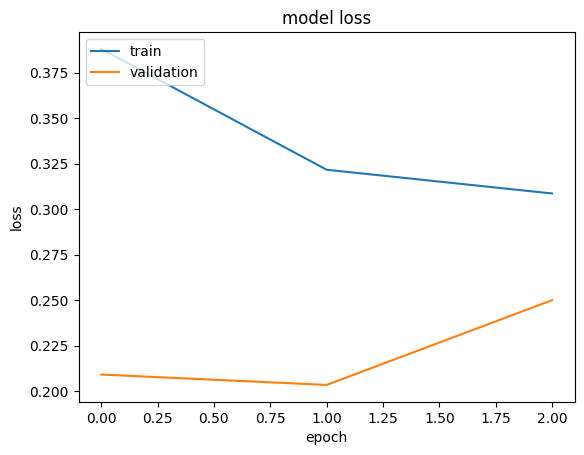

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')


#Regression Scores

In [28]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)


print('Snow Result')
snow_df = pd.DataFrame(index=['RMSE', 'MSE', 'R2'], columns=['Score'])
snow_df.iloc[0, 0] = np.sqrt(mean_squared_error(y_test[:, 0], y_pred[:, 0]))
snow_df.iloc[1, 0] = mean_squared_error(y_test[:, 0], y_pred[:, 0])
snow_df.iloc[2, 0] = r2_score(y_test[:, 0], y_pred[:, 0])
print(snow_df, '\n')


print('Rain Result')
rain_df = pd.DataFrame(index=['RMSE', 'MSE', 'R2'], columns=['Score'])
rain_df.iloc[0, 0] = np.sqrt(mean_squared_error(y_test[:, 1], y_pred[:, 1]))
rain_df.iloc[1, 0] = mean_squared_error(y_test[:, 1], y_pred[:, 1])
rain_df.iloc[2, 0] = r2_score(y_test[:, 1], y_pred[:, 1])
print(rain_df)

137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Snow Result
         Score
RMSE  0.584726
MSE   0.341905
R2    0.590296 

Rain Result
         Score
RMSE  0.570642
MSE   0.325632
R2    0.869354


Text(0.5, 0, 'ith sample')

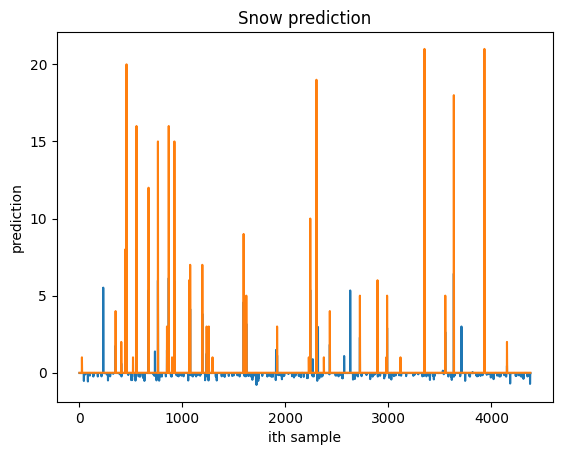

In [29]:
# Snow prediction
plt.plot(y_pred[:, 0])
plt.plot(y_test[:, 0])
plt.title('Snow prediction')
plt.ylabel('prediction')
plt.xlabel('ith sample')

Text(0.5, 0, 'ith sample')

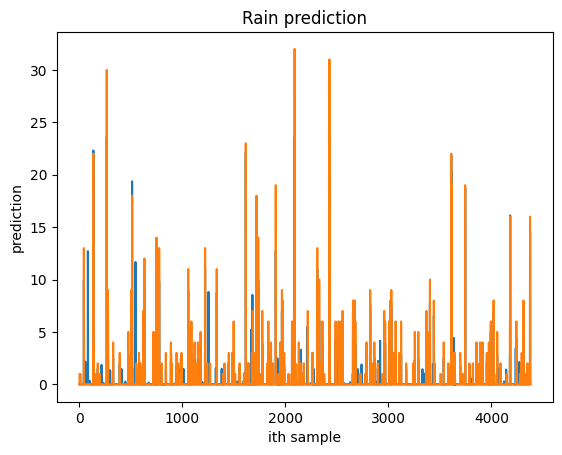

In [30]:
#rain prediction
plt.plot(y_pred[:, 1])
plt.plot(y_test[:, 1])

plt.title('Rain prediction')
plt.ylabel('prediction')
plt.xlabel('ith sample')